In [2]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np
from time import time
import matplotlib.pyplot as plt
from matplotlib import cm
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
dde.config.set_default_float("float64")

Num GPUs Available:  1
Set the default float type to float64


In [29]:
t0 = time()
geom= dde.geometry.Interval(0,2*np.pi)
timedomain = dde.geometry.TimeDomain(0,50)
geotime = dde.geometry.GeometryXTime(geom,timedomain)

def pde(x,y):
    dy_x = dde.grad.jacobian(y,x,i=0,j=0)
    dy_t = dde.grad.jacobian(y,x,i=0,j=1)
    dy_xx = dde.grad.hessian(y,x,i=0,j=0)
    return dy_t + y*dy_x - 0.9*dy_xx - tf.sin(x[:,0:1])

bc = dde.icbc.DirichletBC(geotime,lambda x: 0, lambda _,on_boundary:on_boundary)
ic = dde.icbc.IC(geotime,lambda x:np.sin(x[:,0:1]),lambda _,on_initial:on_initial)

data = dde.data.TimePDE(geotime,pde,[bc,ic],num_domain=30000,num_boundary=500,num_initial=500)

net = dde.nn.FNN([2]+[50]*4+[1],'tanh','Glorot normal')

model5 = dde.Model(data,net)
model5.compile("adam", lr=1e-3)
print("learning rate = ",1e-3)
model5.train(iterations=15000)
model5.compile("L-BFGS")
losshistory, train_state = model5.train()
t1 = time()
print("Total time taken:",t1-t0,"sec")

Compiling model...
Building feed-forward neural network...
'build' took 0.055792 s



/home/diganta5/anaconda3/envs/tf/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-04-22 11:23:18.472640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78977 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


'compile' took 0.590830 s

learning rate =  0.001
Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.96e-01, 2.30e-01, 8.74e-01]    [4.96e-01, 2.30e-01, 8.74e-01]    []  
1000      [1.17e-03, 8.40e-05, 6.31e-04]    [1.17e-03, 8.40e-05, 6.31e-04]    []  
2000      [7.89e-04, 3.49e-04, 3.29e-04]    [7.89e-04, 3.49e-04, 3.29e-04]    []  
3000      [2.44e-04, 2.23e-05, 1.20e-04]    [2.44e-04, 2.23e-05, 1.20e-04]    []  
4000      [1.90e-04, 1.01e-04, 6.02e-05]    [1.90e-04, 1.01e-04, 6.02e-05]    []  
5000      [1.06e-04, 2.74e-05, 3.17e-05]    [1.06e-04, 2.74e-05, 3.17e-05]    []  
6000      [2.35e-04, 3.00e-04, 3.99e-05]    [2.35e-04, 3.00e-04, 3.99e-05]    []  
7000      [5.83e-05, 3.90e-05, 1.53e-05]    [5.83e-05, 3.90e-05, 1.53e-05]    []  
8000      [2.64e-04, 3.56e-04, 7.95e-05]    [2.64e-04, 3.56e-04, 7.95e-05]    []  
9000      [1.75e-04, 1.80e-04, 7.96e-05]    [1.75e-04, 1.80e-04, 7.9

Saving loss history to /home/diganta5/final/loss.dat ...
Saving training data to /home/diganta5/final/train.dat ...
Saving test data to /home/diganta5/final/test.dat ...


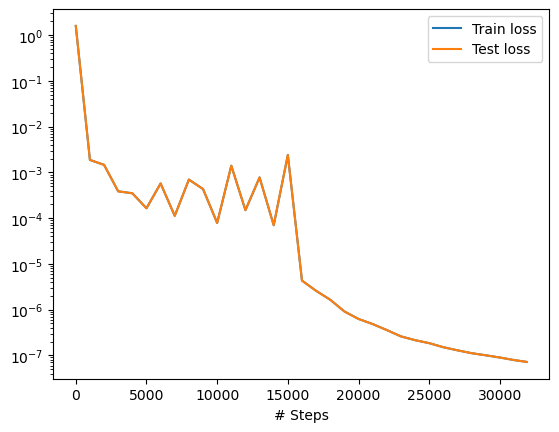

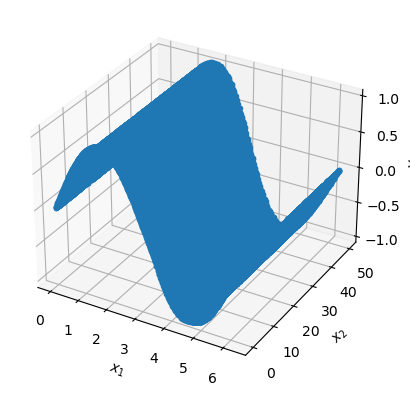

In [30]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Text(0.5, 1.0, '$\\nu$=0.9')

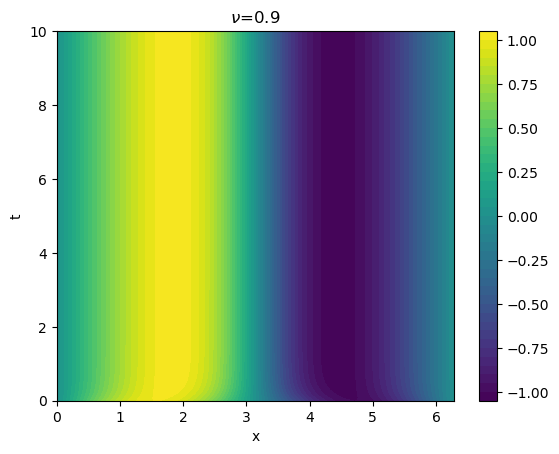

In [31]:
t=np.linspace(0.0,10.0,1000)
x=np.linspace(0.0,2*np.pi,1000)
xx, tt = np.meshgrid(x, t)
X=np.concatenate([xx.reshape(1000,1000,1),tt.reshape(1000,1000,1)],axis=2)
f1 = model5.predict(X.reshape((1000000,2)))
s=plt.contourf(xx,tt,f1.reshape(1000,1000),50)
plt.colorbar(s)
plt.xlabel("x")
plt.ylabel("t")
plt.title(r"$\nu$=0.9")

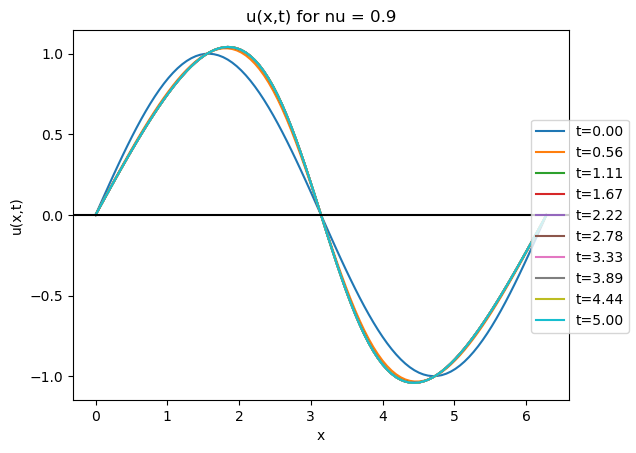

In [41]:
number_of_plots = 10
t1 = np.linspace(0,5,number_of_plots)

fig=plt.figure(1)#,figsize=(10,8)
x = np.linspace(0,2*np.pi,100)
#fig,axes = plt.subplots(number_of_plots,figsize=(6,number_of_plots*6))
for i in range(number_of_plots):
    
    t = t1[i] * np.ones_like(x)
    X_T = np.concatenate([x.reshape(100,1),t.reshape(100,1)],axis=1)
    z = model5.predict(X_T)
    plt.plot(x,z,label="t=%.2f"%(t1[i]))
    
plt.axhline(y=0,xmin=0.0,xmax=2*np.pi,c="black")
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title("u(x,t) for nu = 0.9")
fig.legend(loc='outside right')


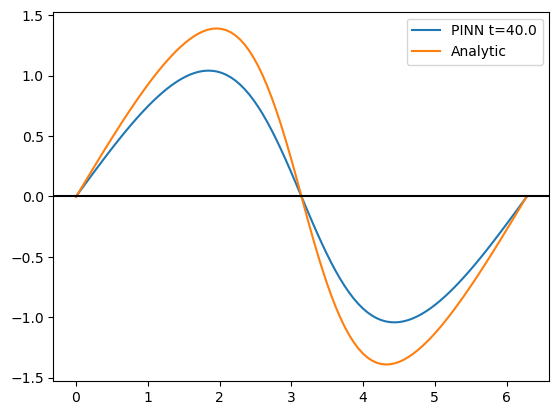

In [42]:
def sgn(x):
    out = []
    for i in x:
        if i<0:
            out.append(1.0)
        else:
            out.append(-1.0)
    return np.array(out)


def u(x,nu):
    return 2*sgn(x-np.pi)*(np.sin(x/2)-1) +2*np.tanh((np.pi-x)/nu)

x = np.linspace(0,2*np.pi,100)
t = 40.0 * np.ones_like(x)
X_T = np.concatenate([x.reshape(100,1),t.reshape(100,1)],axis=1)
z = model5.predict(X_T)
plt.plot(x,z,label="PINN t=40.0")
u_0_9 = u(x,0.9)
plt.plot(x,u_0_9,label='Analytic')
plt.axhline(y=0,xmin=0.0,xmax=2*np.pi,c="black")
plt.legend()


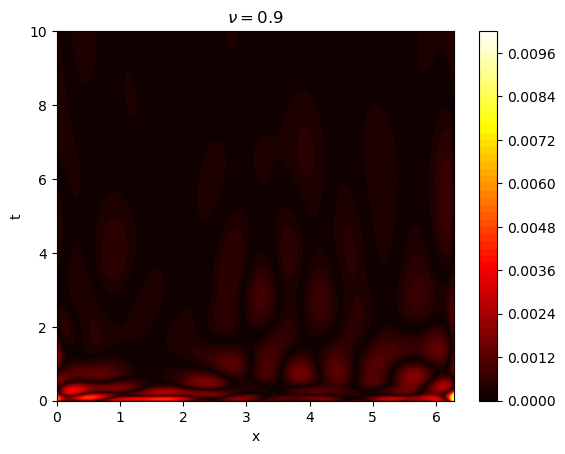

In [45]:
plt.figure(2)#,figsize=(12,10))
t=np.linspace(0,10,1000)
x=np.linspace(0,2*np.pi,1000)
xx, tt = np.meshgrid(x, t)

X=np.concatenate([xx.reshape(1000,1000,1),tt.reshape(1000,1000,1)],axis=2)
f1 = np.abs(model5.predict(X.reshape((1000000,2)),operator=pde))

s=plt.contourf(xx,tt,f1.reshape(1000,1000),50)
cmap = plt.get_cmap('hot')
plt.set_cmap(cmap)
plt.colorbar()
#plt.savefig('R10911.png')
plt.xlabel('x')
plt.ylabel('t')
plt.title(r'$\nu=0.9$')
plt.show()